In [1]:
%matplotlib inline
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image


In [2]:
vgg19 = models.vgg19(pretrained=True).features

for param in vgg19.parameters():
  param.requires_grad = False 

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #use GPU as much as possible

In [4]:
vgg19.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [5]:
def loag_img(path, max_size = 400, shape=None):
  image = Image.open(path).convert('RGB')

  size = min(max(image.size), max_size)

  if shape: # shape is to make sure the style and content are formatted in the same size
    size = shape

  input_transform = transforms.Compose([
                      transforms.Resize(size),
                      transforms.ToTensor(),
                      transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # this normalization will seriously affect the quality of the image!
  ])

  image = input_transform(image).unsqueeze(0)

  return image

In [6]:
img_content = loag_img('City.jpg').to(device)
img_style = loag_img('StarryNight.jpg').to(device)

In [7]:
def img_convert(tensor):
    im = tensor.cpu().clone().detach().numpy()
    im = im.squeeze()
    im = im.transpose(1,2,0)
    #denormalization
    im = im * np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
    im = im.clip(0,1)
    
    return im

(-0.5, 615.5, 399.5, -0.5)

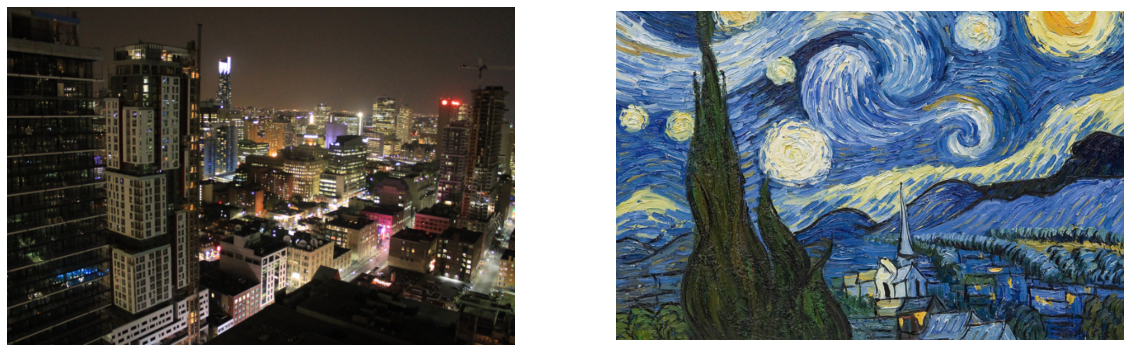

In [8]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img_convert(img_content))
ax1.axis('off')
ax2.imshow(img_convert(img_style))
ax2.axis('off')

In [9]:
def get_features(image, model): #extract features after inputting image into model

  layers = {
      '0': 'conv1_1',
      '5': 'conv2_1',
      '10': 'conv3_1',
      '19': 'conv4_1',
      '21': 'conv4_2', # content extraction
      '28': 'conv5_1',
  } # based on the paper
  features = {}

  for name, layer in model._modules.items():
    image = layer(image) # image will go through each layer
    if name in layers:
      features[layers[name]] = image #store the image value at certain stage

  return features

In [10]:
content_feats = get_features(img_content, vgg19)
style_feats = get_features(img_style, vgg19)

In [11]:
#need to use the gram matrix to eliminate more the content of the style image while maintaining the style

def get_gram_matrix(tensor):
  batch,depth,height,width = tensor.size()
  tensor = tensor.view(depth,height*width)

  gram = torch.mm(tensor,tensor.t())
  return gram

In [12]:
style_grams = {layer:get_gram_matrix(style_feats[layer]) for layer in style_feats} 

In [13]:
style_weights = { #layer at beginning are usually more effective, ratio is important for how much style it will apply to the content image
    'conv1_1': 1,
    'conv2_1': .75,
    'conv3_1': .5,
    'conv4_1': .2,
    'conv5_1': .2,
}

content_weight = 1
style_weight = 1e6

In [14]:
target = img_content.clone().requires_grad_(True).to(device)

In [15]:
show_epoch = 500
optimizer = optim.Adam([target], lr = 0.003)
steps = 10000
num_frames = 500
image_array = np.empty((500,)+img_convert(target).shape) #want only keep certain frames, or it would take too much memory
capture_frames = steps/num_frames


Epoch:  500
total loss:  2070684.25


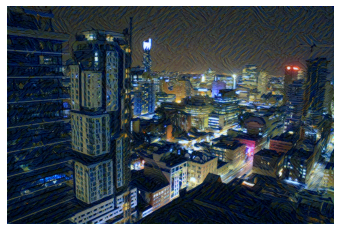

Epoch:  1000
total loss:  776474.375


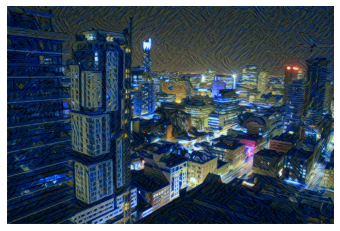

Epoch:  1500
total loss:  541373.5


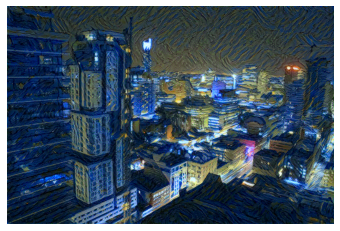

Epoch:  2000
total loss:  389939.875


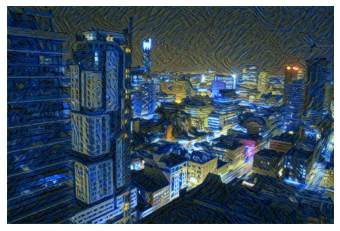

Epoch:  2500
total loss:  278894.3125


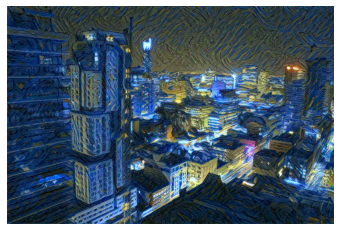

Epoch:  3000
total loss:  196258.234375


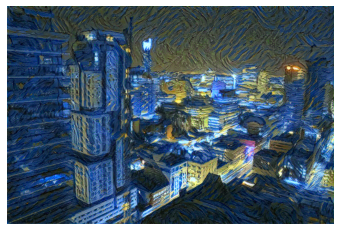

Epoch:  3500
total loss:  135518.9375


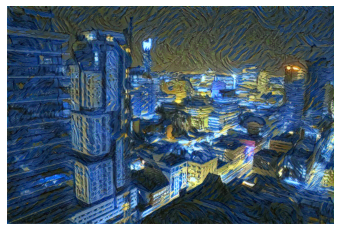

Epoch:  4000
total loss:  92341.15625


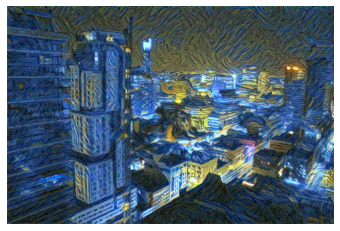

Epoch:  4500
total loss:  63062.07421875


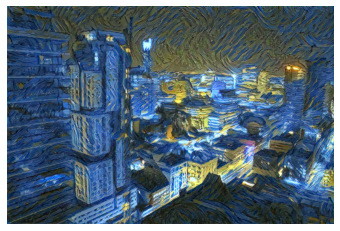

Epoch:  5000
total loss:  44208.78515625


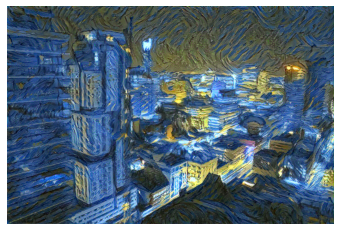

Epoch:  5500
total loss:  33261.1015625


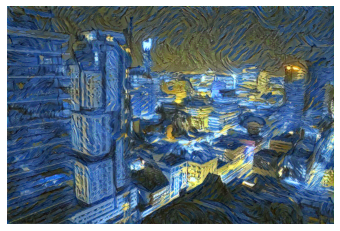

Epoch:  6000
total loss:  26426.724609375


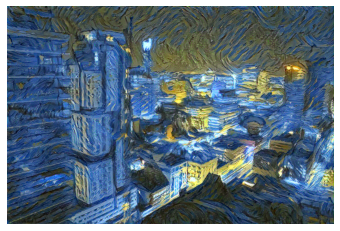

Epoch:  6500
total loss:  22006.8515625


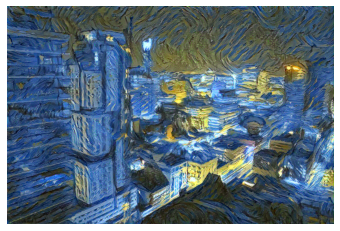

In [ ]:
for i in range(1,steps+1):
  target_feat = get_features(target, vgg19)
  content_loss = torch.mean((target_feat['conv4_2'] - content_feats['conv4_2'])**2) # this formula is from linear regression of calculating loss: mean square error
  
  style_loss_combined = 0
  for layer in style_weights:
    style_feat = target_feat[layer]
    style_loss = torch.mean((get_gram_matrix(style_feat) - style_grams[layer])**2) #similar reasoninng than the content loss calculation
    b,d,h,w = style_feat.shape
    style_loss_combined += style_weights[layer] * style_loss / (d*h*w) # normalize the loss to get the unit loss

  total_loss = content_weight * content_loss + style_weight * style_loss_combined

  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if i % show_epoch == 0:
    print("Epoch: ", i)
    print("total loss: ", total_loss.item())
    plt.imshow(img_convert(target))
    plt.axis('off')
    plt.show()

  if i % capture_frames == 0:
    image_array = np.append(image_array,img_convert(target))

In [ ]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,10))

ax1.imshow(img_convert(img_content))
ax1.axis('off')
ax2.imshow(img_convert(img_style))
ax2.axis('off')
ax3.imshow(img_convert(target))
ax3.axis('off')

In [ ]:
# #create a video

# import cv2

# vid_name = 'output.mp4'
# frame_height, frame_width,_ = im_convert(target).shape
# vid = cv2.VideoWriter(vid_name, cv2.VideoWriter_fourcc(*'XVID'), 30,(frame_width, frame_height))

# for i in range(num_frames):
#   img = image_array[i]*255 # denormalization (0 to 1) and convert to rgb 
#   img = np.array(img, dtype = np.uint8)
#   vid.write(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# vid.release()

In [ ]:
# from google.colab import files

# files.download(vid_name)

In [ ]:
1e4